In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from scipy import stats
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
#import statistics

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import constants as const
#import sciann as sn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

import functools
import evidential_deep_learning as edl


2.8.1


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
#data_turbines = pd.read_csv('../Dataset/Dataset_reduced.csv')
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (731709, 6)


,turbine,V,theta,W,T,P
731704,R80711,16.450001,0.205600,1.800133,10440.8,1969900.0
731705,R80790,16.440000,0.194953,1.800133,10597.2,1999450.0
731706,R80711,16.370000,0.199840,1.801180,10536.8,1988610.0
731707,R80711,16.480000,0.194779,1.798038,10500.0,1978570.0
731708,R80790,16.350000,0.170170,1.801180,10558.8,1993020.0


In [3]:
# Clean dataset
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
731704,16.450001,0.205600,1.800133,10440.8,1969900.0
731705,16.440000,0.194953,1.800133,10597.2,1999450.0
731706,16.370000,0.199840,1.801180,10536.8,1988610.0
731707,16.480000,0.194779,1.798038,10500.0,1978570.0
731708,16.350000,0.170170,1.801180,10558.8,1993020.0


In [5]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.shape)
print(test_dataset.shape)

(585367, 5)
(146342, 5)


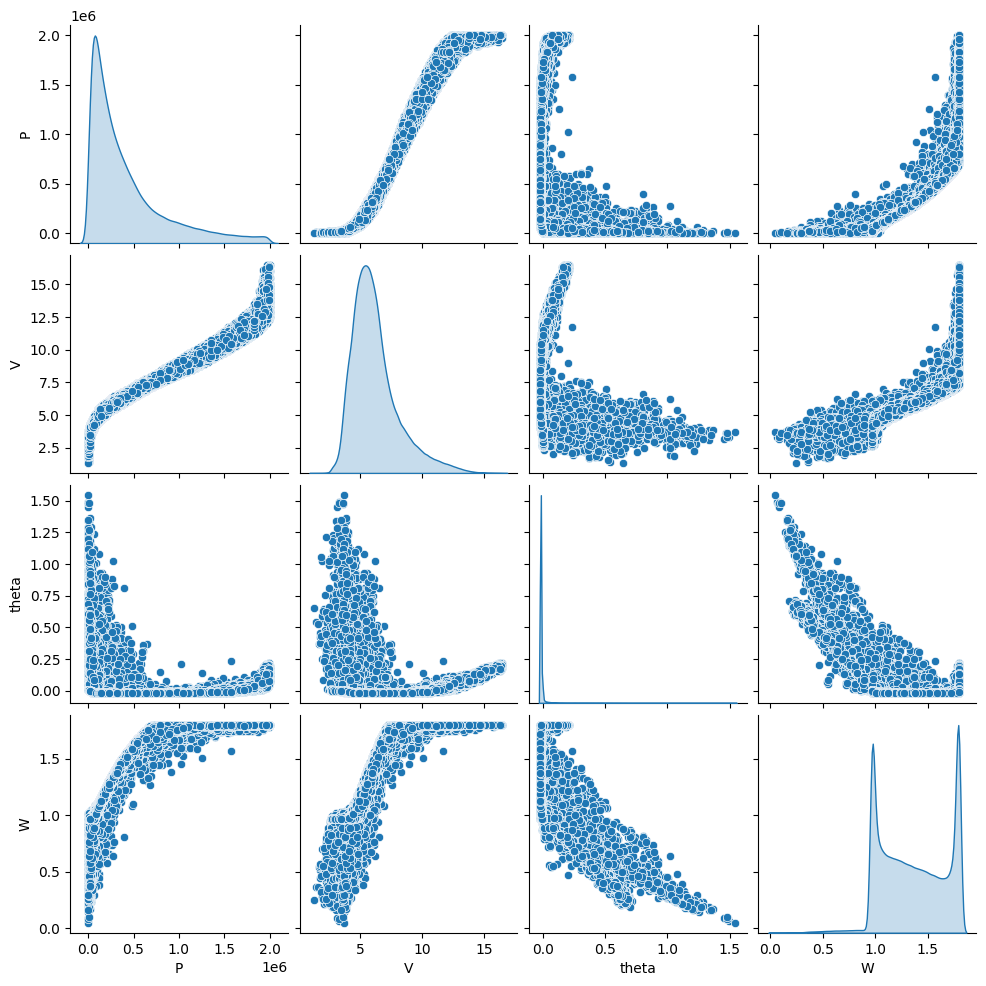

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(train_dataset[['P', 'V', 'theta', 'W']], diag_kind='kde')

In [7]:
# Check overal statistis of each input feature 
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,585367.0,6.217769,1.898787,1.330000,4.920000,5.840000,7.030000,1.648000e+01
theta,585367.0,-0.007787,0.052708,-0.018850,-0.017453,-0.017279,-0.015533,1.546711e+00
W,585367.0,1.357096,0.305530,0.046077,1.078613,1.336224,1.648289,1.803274e+00
T,585367.0,2547.565820,2179.993028,0.010000,1006.700000,1925.130000,3298.120100,1.066140e+04
P,585367.0,426471.244415,430039.140163,10.000000,115940.000000,274239.990000,578219.970000,1.999940e+06


In [8]:
# Normalization

print(train_dataset.describe().transpose()[['mean', 'std']])

#tf.enable_eager_execution()
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

# adapt() method does not work, so we standarize each feature by hand

""" V = np.array(train_features['V'])
theta = np.array(train_features['theta'])
W = np.array(train_features['W'])
#Torque = np.array(train_labels['T'])
#Power = np.array(train_labels['P'])
Power = np.array(train_labels)

V_avrg = np.average(V[:])
V_std = np.std(V[:])
theta_avrg = np.average(theta[:])
theta_std = np.std(theta[:])
W_avrg = np.average(W[:])
W_std = np.std(W[:])
#T_avrg = np.average(Torque[:])
#T_std = np.std(Torque[:])
P_avrg = np.average(Power[:])
P_std = np.std(Power[:])

V[:] = ( V[:] - V_avrg ) / V_std
theta[:] = ( theta[:] - theta_avrg ) / theta_std
W[:] = ( W[:] - W_avrg ) / W_std
#Torque[:] = ( Torque[:] - T_avrg ) / T_std
Power[:] = ( Power[:] - P_avrg ) / P_std
 """

# Normalize pandas dataframe
#train_features=(train_features-train_features.mean())/train_features.std()
#test_features=(test_features-test_features.mean())/test_features.std()
#train_labels=(train_labels-train_labels.mean())/train_labels.std()
#test_features=(test_labels-test_labels.mean())/test_labels.std()

train_dataset_norm=(train_dataset-train_dataset.mean())/train_dataset.std()
test_dataset_norm=(test_dataset-test_dataset.mean())/test_dataset.std()

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                mean            std
V           6.217769       1.898787
theta      -0.007787       0.052708
W           1.357096       0.305530
T        2547.565820    2179.993028
P      426471.244415  430039.140163

Normalized dataset
               mean  std
V      1.549104e-16  1.0
theta  4.839586e-17  1.0
W     -3.130012e-16  1.0
T     -4.325403e-16  1.0
P      3.716297e-16  1.0


In [9]:
# Split features from labels

train_features = train_dataset_norm.copy()
test_features = test_dataset_norm.copy()

train_labels = train_features.pop('P')
test_labels = test_features.pop('P')

print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)


(585367, 4)
(585367,)
(146342, 4)
(146342,)


In [12]:
# 1-input linear model 

""" x = np.array(train_features['V'])
inputs = tf.keras.Input(shape=(1,))

model = tf.keras.Sequential([
    inputs,
    layers.Dense(units=1)
])

model.summary() """


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2023-02-24 08:07:20.470289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 08:07:20.522037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-24 08:07:20.522054: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-24 08:07:20.522964: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [10]:
# Define our model with an evidential output

inputs = tf.keras.Input(shape=(3,))
model = tf.keras.Sequential([
    inputs,
    layers.Dense(units=8, activation='tanh'),
    layers.Dense(units=8, activation='tanh'),
    layers.Dense(units=8, activation='tanh'),
    layers.Dense(units=8, activation='tanh'),
    #layers.Dense(units=1)
    edl.layers.DenseNormalGamma(1),
])

model.summary()
#model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=EvidentialRegressionLoss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_normal_gamma (DenseNo  (None, 4)                36        
 rmalGamma)                                                      
                                                                 
Total params: 284
Trainable params: 284
Non-trainable params: 0
__________________________________________________________

2023-02-24 09:20:23.172992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 09:20:23.194400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-24 09:20:23.194417: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-24 09:20:23.194766: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [11]:
# Train the model

x = train_features[['V','theta','W']]

In [12]:
%%time
history = model.fit(
    #train_features,
    x,
    train_labels,
    #epochs=100,
    epochs=10,
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Epoch 1/10
14635/14635 - 8s - loss: -1.9373e+00 - val_loss: -2.0355e+00 - 8s/epoch - 533us/step
Epoch 2/10
14635/14635 - 7s - loss: -2.0398e+00 - val_loss: -2.0465e+00 - 7s/epoch - 499us/step
Epoch 3/10
14635/14635 - 7s - loss: -2.0617e+00 - val_loss: -2.0638e+00 - 7s/epoch - 478us/step
Epoch 4/10
14635/14635 - 7s - loss: -2.0726e+00 - val_loss: -2.1223e+00 - 7s/epoch - 472us/step
Epoch 5/10
14635/14635 - 7s - loss: -2.0810e+00 - val_loss: -2.1199e+00 - 7s/epoch - 479us/step
Epoch 6/10
14635/14635 - 7s - loss: -2.0888e+00 - val_loss: -2.1238e+00 - 7s/epoch - 475us/step
Epoch 7/10
14635/14635 - 7s - loss: -2.0954e+00 - val_loss: -2.1457e+00 - 7s/epoch - 478us/step
Epoch 8/10
14635/14635 - 7s - loss: -2.1012e+00 - val_loss: -2.0457e+00 - 7s/epoch - 477us/step
Epoch 9/10
14635/14635 - 7s - loss: -2.1056e+00 - val_loss: -2.1215e+00 - 7s/epoch - 481us/step
Epoch 10/10
14635/14635 - 7s - loss: -2.1112e+00 - val_loss: -2.1369e+00 - 7s/epoch - 487us/step
CPU times: user 1min 27s, sys: 4.68 s, 

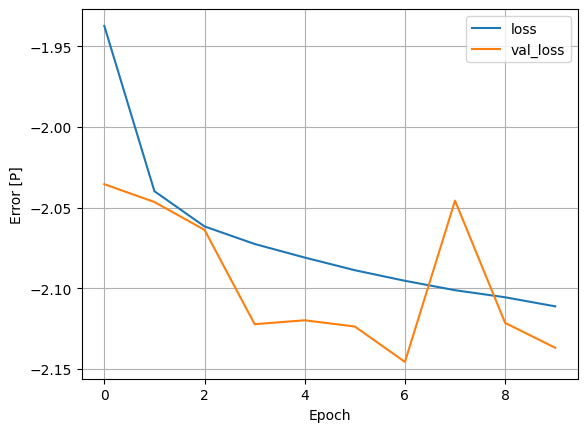

In [13]:
# Plot the loss

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [P]')
plt.legend()
plt.grid(True)


In [14]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

(146342, 3)
(146342, 4)
(146342,)


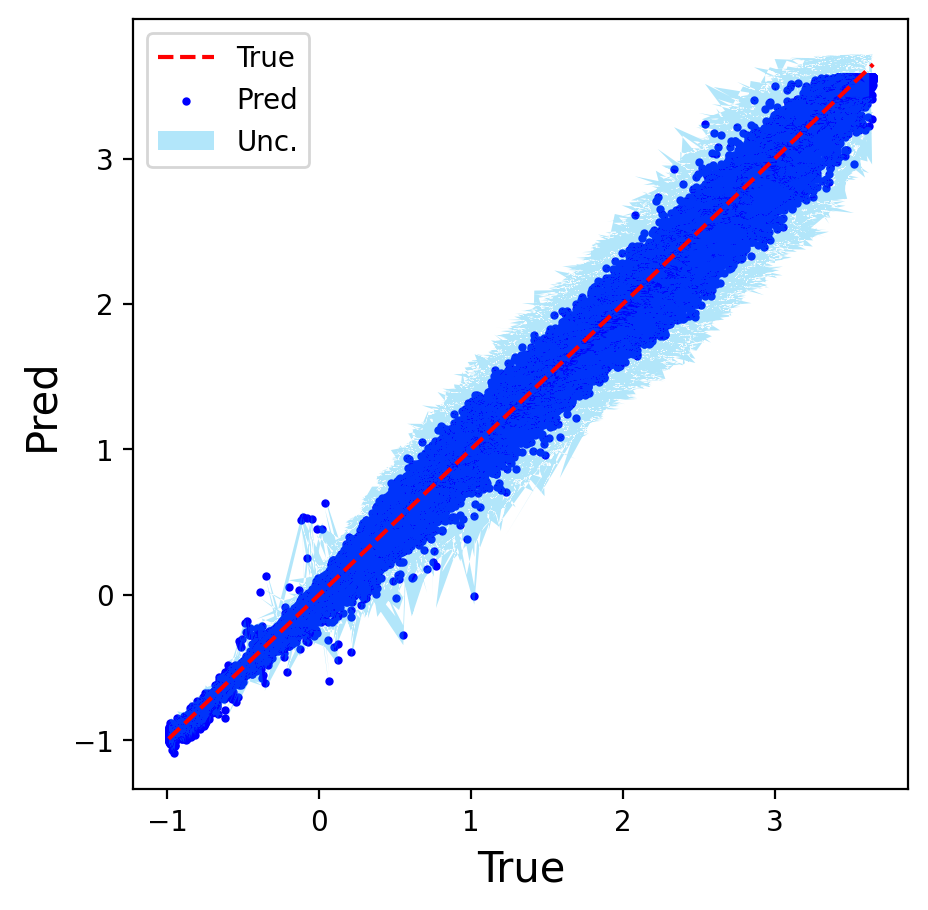

Test MAE: 0.03844683376202735


In [15]:
# Pred vs True values

""" #test_pred = model.predict(test_features[['V','theta','W']]).flatten()

#print(test_pred/test_labels)
#print(test_labels)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

test_result = model.evaluate(test_features[['V','theta','W']], test_labels, verbose=0)
print("Test MAE: "+str(test_result)) """

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

print(x_test.shape)
print(y_pred.shape)
print(y_true.shape)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred[:,0])
print("Test MAE: "+str(test_mae))

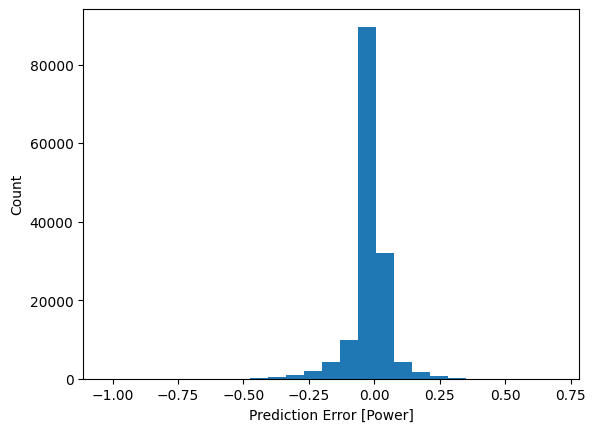

In [16]:
# Check the error distribution
error = y_pred[:,0] - y_true
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Power]')
_ = plt.ylabel('Count')


In [17]:
# Save the model
model.save('Power_model')
model.save_weights('Power_weights.h5')


2023-02-24 09:24:46.456201: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Power_model/assets


INFO:tensorflow:Assets written to: Power_model/assets


In [3]:
# Normalize data

# Define inputs and outputs
X_data = data_turbines[['V','theta','W']]
Y_data = data_turbines[['T','P']]

X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')

# Fit Cp instead of Torque
#Y_data[:,0] = Y_data[:,0]*const.gear*X_data[:,2] / (0.5*const.rho*const.A*X_data[:,0]**3)

# Transform inputs and outputs to normalized units, with its mean and deviation

x1_avrg = np.average(X_data[:,0])
x1_std = np.std(X_data[:,0])
x2_avrg = np.average(X_data[:,1])
x2_std = np.std(X_data[:,1])
x3_avrg = np.average(X_data[:,2])
x3_std = np.std(X_data[:,2])
y1_avrg = np.average(Y_data[:,0])
y1_std = np.std(Y_data[:,0])
y2_avrg = np.average(Y_data[:,1])
y2_std = np.std(Y_data[:,1])

X_data[:,0] = ( X_data[:,0] - x1_avrg ) / x1_std
X_data[:,1] = ( X_data[:,1] - x2_avrg ) / x2_std
X_data[:,2] = ( X_data[:,2] - x3_avrg ) / x3_std
Y_data[:,0] = ( Y_data[:,0] - y1_avrg ) / y1_std
Y_data[:,1] = ( Y_data[:,1] - y2_avrg ) / y2_std

In [4]:
# Set up the NN arquitecture to fit the data

from pickletools import optimize

V = sn.Variable('V')
theta = sn.Variable('theta')
W = sn.Variable('W')

# NN arquitecture
architecture = []
N_layers = 4
N_neurons = 8
for i in range(N_layers):
    architecture.append(N_neurons)

#Torque = sn.Functional('Torque',variables=[V,theta,W],hidden_layers=[30,30],activation='tanh')
Torque = sn.Functional('Torque',variables=[V,theta,W],hidden_layers=architecture,activation='tanh')

# Set up the optimization algorithm
data1 = sn.Data(Torque)
model = sn.SciModel(inputs=[V,theta,W], targets=data1,loss_func='mae',optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 V (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 theta (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 W (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 concat (Concatenate)           (None, 3)            0           ['V[0][0]',                      
                                                                  'theta[0][0]',              

In [5]:
from tabnanny import verbose

# Split the data in training and test/validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=38)

train_size = len(X_train[:,0])
test_size = len(X_test[:,0])


Total samples: 585367 
Batch size: 256 
Total batches: 2287 

Epoch 1/1000


2023-02-21 11:07:34.175235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 11:07:34.225670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-21 11:07:34.225687: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-21 11:07:34.226720: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

2287/2287 [==============================] - 2s 666us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0531 - lr: 0.0200 - time: 1.7155
Epoch 2/1000
2287/2287 [==============================] - 2s 663us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0473 - lr: 0.0200 - time: 1.6196
Epoch 3/1000
2287/2287 [==============================] - 2s 670us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0462 - lr: 0.0200 - time: 1.6355
Epoch 4/1000
2287/2287 [==============================] - 2s 658us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0457 - lr: 0.0200 - time: 1.6184
Epoch 5/1000
2287/2287 [==============================] - 2s 663us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0449 - lr: 0.0200 - time: 1.6322
Epoch 6/1000
2287/2287 [==============================] - 2s 660us/step - batch: 1143.0000 - size: 255.9541 - loss: 0.0447 - lr: 0.0200 - time: 1.6263
Epoch 7/1000
2287/2287 [==============================] - 2s 658us/step - batch: 1143.0000 - size: 255.9541

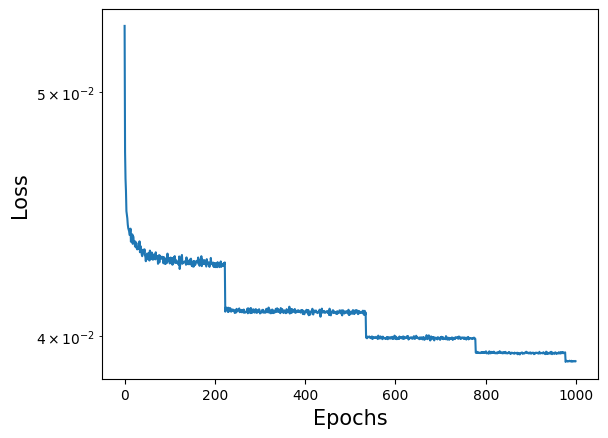

In [6]:
# Train the model

#_learning_rate = 0.02
_learning_rate = 0.02
#_epochs = 10
_epochs = 1000
_batch_size = 256
running = model.train([X_train[:,0],X_train[:,1],X_train[:,2]],Y_train[:,0],batch_size=_batch_size,learning_rate=_learning_rate, epochs=_epochs,verbose=1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()


In [6]:
# save model weights 
#architecture_string = str(N_layers)+'layers-'+str(N_neurons)+'neurons'
#model.save_weights('weights-'+architecture_string+'.hdf5')
#model.save_weights('weights.hdf5')

# load model weights
architecture_string = str(N_layers)+'layers-'+str(N_neurons)+'neurons'
model.load_weights('weights-'+architecture_string+'.hdf5')
#model.load_weights('weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('my_model.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

2023-02-21 17:45:43.985008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 17:45:44.040589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-21 17:45:44.040606: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-21 17:45:44.041348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

NameError: name 'running' is not defined

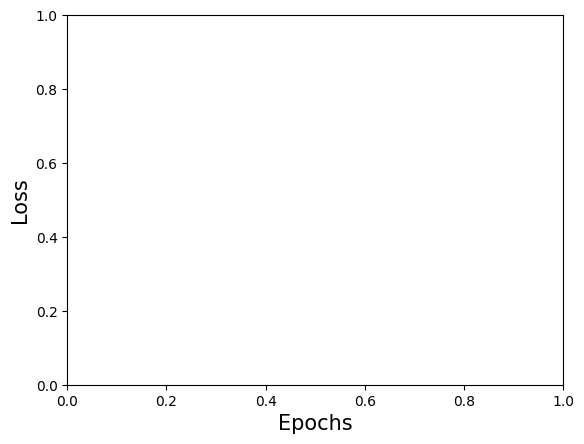

In [49]:
# Plot loss

plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(running.history['loss'])
plt.show()
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss (logscale)',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()

""" plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss (logscale)',fontsize=15)
plt.semilogy(running.history['val_loss'])
plt.show() """

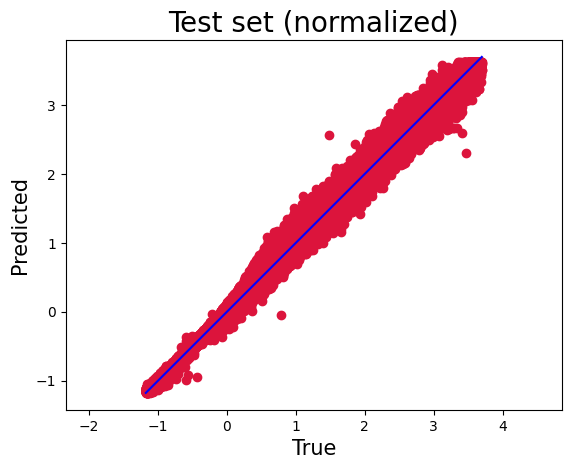

Normalized test MAE: 0.039311151474792506
Normalized test MSE: 0.004522586149243572
Normalized test MAPE: 49.05445757258781


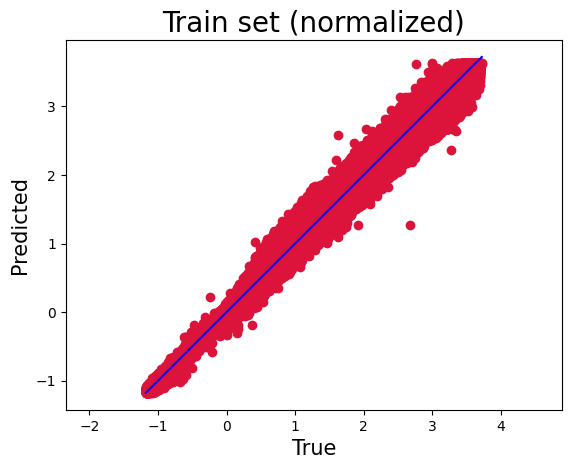

Normalized train MAE: 0.039364775593925504
Normalized train MSE: 0.0045362064309479155
Normalized train MAPE: 37.348408012269935


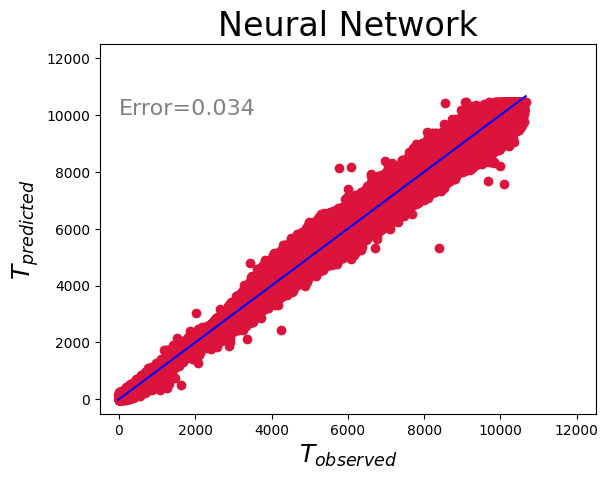

Test MAE: 85.8365574457287
Test MSE: 21567.390575795704
Test MAPE: 4.1798562078315955


In [8]:
# Evaluate the model

# mean absolute percentage error (MAPE)
from tkinter import Y

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    # Remove low values to compute MAPE
    q_low = np.quantile(ytrue,0.01)
    ypred = ypred[ ytrue > q_low ]
    ytrue = ytrue[ ytrue > q_low ]
    
    #mape_i = np.zeros(len(ytrue))
    #mape_i = np.abs((ypred-ytrue)/ytrue)*100
    #mape_i = mape_i[ mape_i < 1e3]

    #return np.mean(mape_i)
    return np.mean(np.abs((ytrue - ypred) / ytrue)) * 100

""" def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    return np.mean(np.abs((ytrue - ypred) / ytrue)) * 100 """

# Loss function on test set

y_exact = np.zeros(test_size)
y_pred = np.zeros(test_size)
y_exact[:] = Y_test[:,0]
y_pred[:] = Torque.eval([X_test[:,0],X_test[:,1],X_test[:,2]])

""" y_exact = np.zeros(len(Y_data[:,0]))
y_pred = np.zeros(len(Y_data[:,0]))
y_exact[:] = Y_data[:,0]
y_pred[:] = Torque.eval([X_data[:,0],X_data[:,1],X_data[:,2]]) """

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Test set (normalized)',fontsize=20)
plt.show()

print("Normalized test MAE:", mean_absolute_error(y_exact,y_pred))
print("Normalized test MSE:", mean_squared_error(y_exact,y_pred))
print("Normalized test MAPE:", mape(y_exact,y_pred))

# Loss function on training set

y_exact = np.zeros(train_size)
y_pred = np.zeros(train_size)
y_exact[:] = Y_train[:,0]
y_pred[:] = Torque.eval([X_train[:,0],X_train[:,1],X_train[:,2]])

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Train set (normalized)',fontsize=20)
plt.show()

print("Normalized train MAE:", mean_absolute_error(y_exact,y_pred))
print("Normalized train MSE:", mean_squared_error(y_exact,y_pred))
print("Normalized train MAPE:", mape(y_exact,y_pred))

# Evaluation on the original dataset (without normalization)


#y_exact = np.zeros(test_size)
#y_pred = np.zeros(test_size)
#y_exact[:] = Y_test[:,0] * y1_std + y1_avrg
#y_pred[:] = Torque.eval([X_test[:,0],X_test[:,1],X_test[:,2]]) * y1_std + y1_avrg

y_exact = np.zeros(len(Y_data[:,0]))
y_pred = np.zeros(len(Y_data[:,0]))
y_exact[:] = Y_data[:,0] * y1_std + y1_avrg
y_pred[:] = Torque.eval([X_data[:,0],X_data[:,1],X_data[:,2]]) * y1_std + y1_avrg

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

error_fit = mean_absolute_error(y_exact,y_pred) / np.mean(y_exact)
p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('$T_{observed}$',fontsize=18)
plt.ylabel('$T_{predicted}$',fontsize=18)
plt.title('Neural Network',fontsize=24)
plt.text(0,10000,'Error='+str(round(error_fit,3)),fontsize=16, color='grey')
plt.xlim([-500,12500])
plt.ylim([-500,12500])
#plt.axis('equal')
plt.show()

""" p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Neural Network fit, MAPE='+str(round(mape(y_exact,y_pred),1))+'%',fontsize=18)
plt.show() """

print("Test MAE:", mean_absolute_error(y_exact,y_pred))
print("Test MSE:", mean_squared_error(y_exact,y_pred))
print("Test MAPE:", mape(y_exact,y_pred))

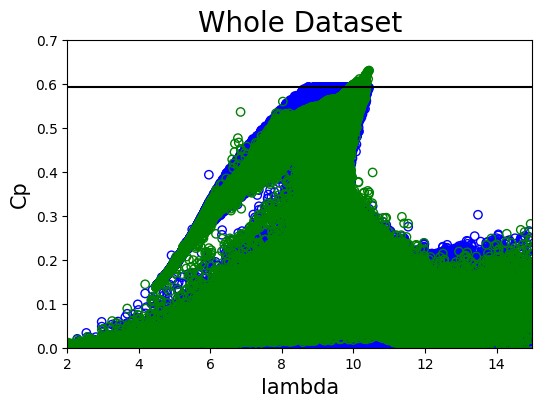

Predicciones no físicas: 1589 (0.21716283385881546 %)


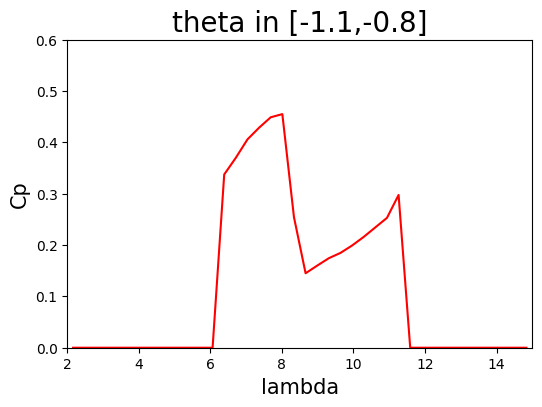

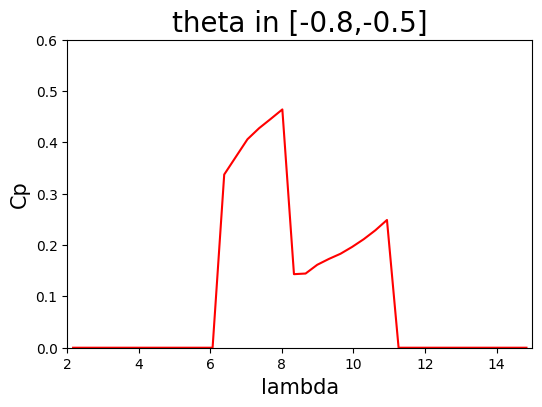

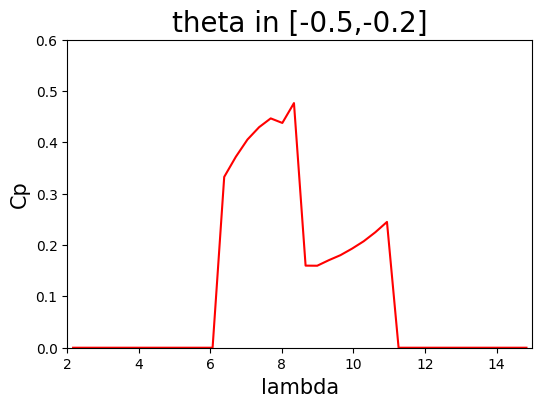

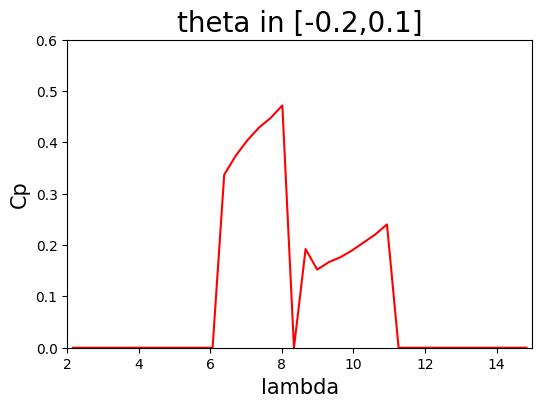

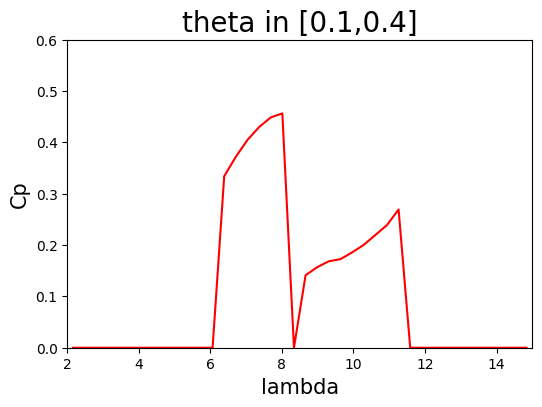

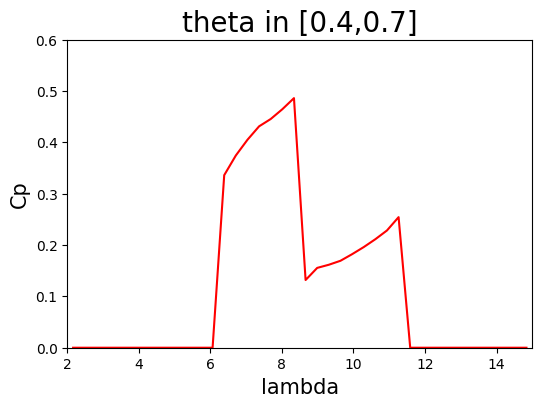

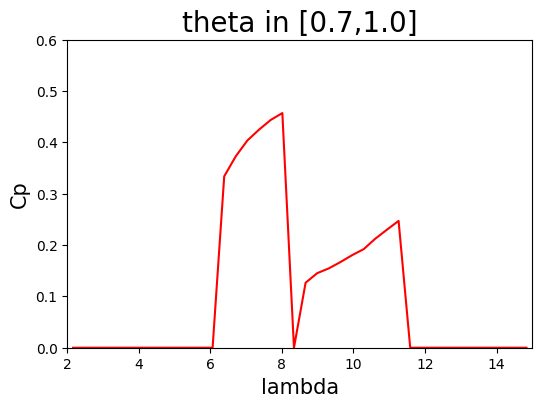

In [9]:
# Cp vs lambda

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def Cp_fromT(Tgen, Vw, Wwt):

    Tt = Tgen * const.gear
    Pturbina = Tt* Wwt
    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp    

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

def Power( Tgen, Vw, Wwt ):

    Cp = Cp_fromT(Tgen,Vw, Wwt)
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3

    return Pturbina

# Prediction of torque
T_predicted = np.zeros(len(X_data[:,0]))
T_predicted[:] = Torque.eval([X_data[:,0],X_data[:,1],X_data[:,2]]) * y1_std + y1_avrg 

# Convert to non-normalized units
X_data_def = np.zeros((len(X_data[:,0]),5))
Y_data_def = np.zeros((len(X_data[:,0]),5))

X_data_def[:,0] = X_data[:,0] * x1_std + x1_avrg
X_data_def[:,1] = X_data[:,1] * x2_std + x2_avrg
X_data_def[:,2] = X_data[:,2] * x3_std + x3_avrg
Y_data_def[:,0] = Y_data[:,0] * y1_std + y1_avrg
Y_data_def[:,1] = Y_data[:,1] * y2_std + y2_avrg

# Cp and lambda
Cp_data = np.zeros(len(X_data_def[:,0]))
Cp_predicted = np.zeros(len(X_data_def[:,0]))
lambd_data = np.zeros(len(X_data_def[:,0]))

Cp_data[:] = Cp_fromT(Y_data_def[:,0], X_data_def[:,0], X_data_def[:,2])
lambd_data = lambd(X_data_def[:,0], X_data_def[:,2])
Cp_predicted[:] = Cp_fromT(T_predicted[:], X_data_def[:,0], X_data_def[:,2])

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([2,15])
plt.ylim([0,0.7])
plt.show()

# Count data with Cp>0.593
def getCount(listOfElems, cond = None):
    'Returns the count of elements in list that satisfies the given condition'
    if cond:
        count = sum(cond(elem) for elem in listOfElems)
    else:
        count = len(listOfElems)    
    return count
N_count = getCount( Cp_predicted, lambda x: x>Cp_max) 
print("Predicciones no físicas: "+str(N_count)+" ("+str(N_count/len(Cp_predicted)*100)+" %)")

# Construct Cp vs lambda for different theta
lmin = 2
lmax = 15
nbins = 40
Cp_estimated = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

# theta binning
theta_min = -1.1 *np.pi/180.0        # (degree to rad)
theta_max = 1.0  *np.pi/180.0
nangles = 7
da = (theta_max - theta_min) / nangles

theta_data = np.zeros(len(X_data[:,1]))
theta_data[:] = X_data[:,1]

for i in range(nangles):
    angle_l = theta_min + i*da
    angle_h = angle_l + da
    angle = (angle_l + angle_h)/2

    cond_angle = (angle_l<theta_data) & (theta_data<angle_h)
    theta_prov = theta_data[ cond_angle ]
    lambd_prov = lambd_data[ cond_angle ]
    Cp_prov = Cp_predicted[ cond_angle ]

    Cp_estimated[0]=0.0
    for j in range(nbins):
        lambdal = lmin + j*dl
        lambdar = lambdal + dl

        # Median of Cp in the bin j
        lambd_estimated[j] = (lambdal+lambdar)/2.0
        l_subset = (lambdal<lambd_prov) & (lambd_prov<lambdar)  # subset of lambda points of the bin
        Cpj = Cp_prov[l_subset]     # Cp distribution of bin j
        if (len(Cpj)>0):
            #Cp_estimated[i]=statistics.median(Cpj)
            Cp_estimated[j]=statistics.mean(Cpj)
            #Cp_estimated[j]=np.max(Cpj)
            #Cp_estimated[j]=np.percentile(Cpj,95)
        else:
            #Cp_estimated[j]=Cp_estimated[j-1]
            Cp_estimated[j]=0.0

    plt.figure(figsize=(6,4))
    plt.xlabel('lambda',fontsize=15)
    plt.ylabel('Cp',fontsize=15)
    plt.plot(lambd_estimated, Cp_estimated, 'r-')
    #plt.title('theta='+str( round(angle*180/np.pi,2) ),fontsize=20)
    plt.title('theta in ['+str( round(angle_l*180/np.pi,2) )+','+str( round(angle_h*180/np.pi,2) )+']',fontsize=20)
    plt.xlim([2,15])
    plt.ylim([0,0.6])
    plt.show()


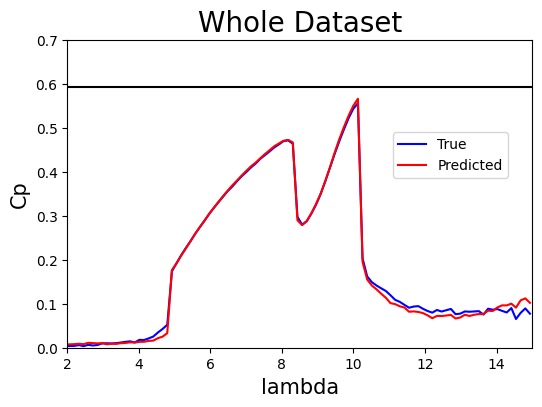

In [21]:
# Cp curve

# Cp and lambda
Cp_data = np.zeros(len(X_data_def[:,0]))
Cp_predicted = np.zeros(len(X_data_def[:,0]))
lambd_data = np.zeros(len(X_data_def[:,0]))

Cp_data[:] = Cp_fromT(Y_data_def[:,0], X_data_def[:,0], X_data_def[:,2])
lambd_data = lambd(X_data_def[:,0], X_data_def[:,2])
Cp_predicted[:] = Cp_fromT(T_predicted[:], X_data_def[:,0], X_data_def[:,2])

# Estimate the Cp curve with an iterative median estimation technique. 
nbins = 100
Cp_estimated = np.zeros(nbins)
Cp_estimated_NN = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

Cp_estimated[0]=0.0
Cp_estimated_NN[0]=0.0
for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_data) & (lambd_data<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_data[l_subset]     # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated[i]=statistics.median(Cpi)
        #Cp_estimated[i]=statistics.mean(Cpi)
        #Cp_estimated[i]=np.max(Cpi)
        #Cp_estimated[i]=np.percentile(Cpi,95)
    else:
        Cp_estimated[i]=Cp_estimated[i-1]
    Cpi = Cp_predicted[l_subset]     # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated_NN[i]=statistics.median(Cpi)
        #Cp_estimated[i]=statistics.mean(Cpi)
        #Cp_estimated[i]=np.max(Cpi)
        #Cp_estimated[i]=np.percentile(Cpi,95)
    else:
        Cp_estimated_NN[i]=Cp_estimated_NN[i-1]

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'b-',label=True)
plt.plot(lambd_estimated, Cp_estimated_NN, 'r-',label='Predicted')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([2,15])
plt.ylim([0,0.7])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()